In [71]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.fft import fft
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


In [99]:
df=yf.download("AAPL",interval="1m",period="1d")

[*********************100%***********************]  1 of 1 completed


In [101]:
df['delta'] = np.append(np.array([0]),np.diff(df['Adj Close'].values))
df['delta'].head()

Datetime
2023-07-21 09:30:00-04:00    0.000000
2023-07-21 09:31:00-04:00   -0.025009
2023-07-21 09:32:00-04:00    0.040710
2023-07-21 09:33:00-04:00    0.159393
2023-07-21 09:34:00-04:00    0.149902
Name: delta, dtype: float64

In [104]:
df.shape

(97, 10)

In [105]:
sp = np.fft.fft(df['delta'].values)
sp.shape

(97,)

In [106]:
df['theta'] = np.arctan(sp.imag/sp.real)
numValues = len(df)
numValuesHalf = numValues / 2
df['amplitude'] = np.sqrt(sp.real**2 + sp.imag**2)/numValuesHalf
df['freq'] = np.fft.fftfreq(sp.size, d=1)
df.head()

,Open,High,Low,Close,Adj Close,Volume,delta,theta,amplitude,freq
Datetime,,,,,,,,,,
2023-07-21 09:30:00-04:00,194.100006,194.360001,193.899994,194.315002,194.315002,3137569,0.000000,-0.000000,0.017083,0.000000
2023-07-21 09:31:00-04:00,194.320007,194.520004,193.919998,194.289993,194.289993,325804,-0.025009,0.627879,0.023338,0.010309
2023-07-21 09:32:00-04:00,194.289993,194.630005,194.270004,194.330704,194.330704,300038,0.040710,1.532572,0.019500,0.020619
2023-07-21 09:33:00-04:00,194.355896,194.600006,194.270004,194.490097,194.490097,253953,0.159393,-0.529019,0.028634,0.030928
2023-07-21 09:34:00-04:00,194.500000,194.960007,194.470001,194.639999,194.639999,482357,0.149902,0.814857,0.020245,0.041237


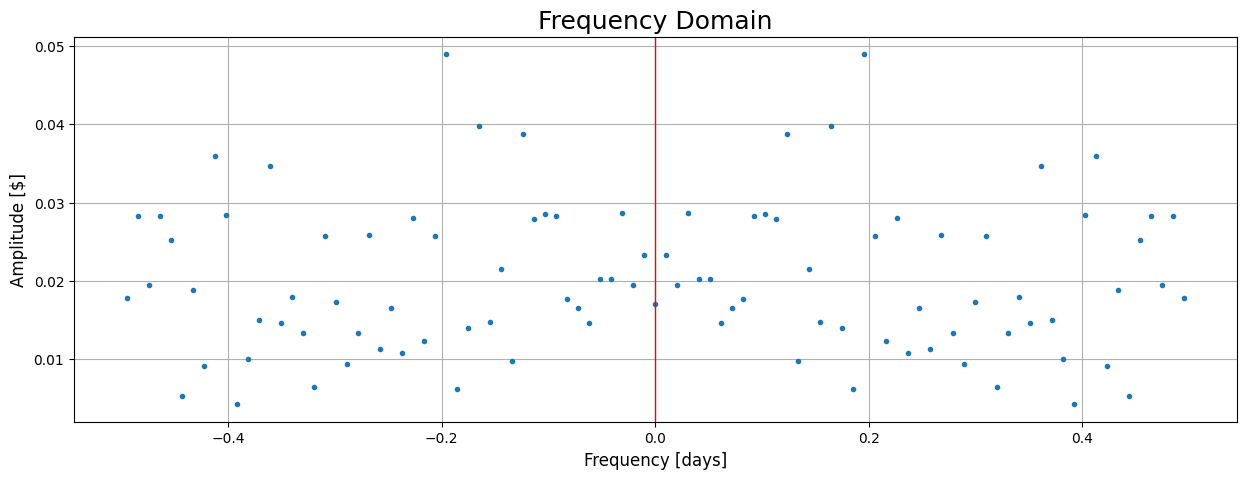

In [107]:
plt.figure(figsize=(15,5))
plt.plot(df['freq'],df['amplitude'].values, '.')
plt.axvline(x=0, ymin=0, ymax = 1, linewidth=1, color='r')
plt.ylabel('Amplitude [$]', fontsize=12)
plt.xlabel('Frequency [days]', fontsize=12)
plt.title('Frequency Domain', fontsize=18)
plt.grid()

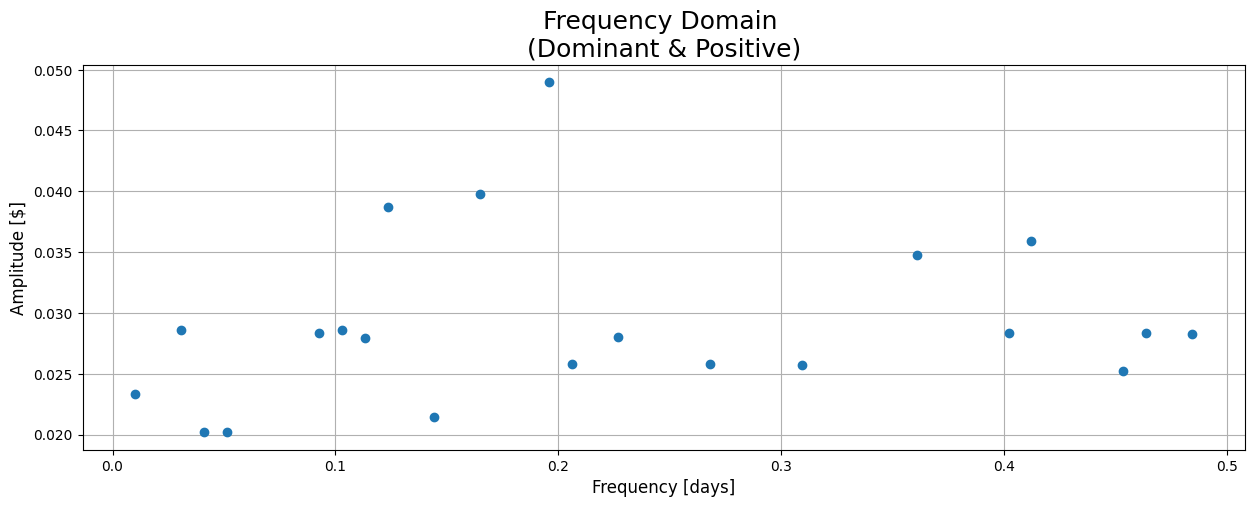

In [126]:
meanAmp = df['amplitude'].mean()
stdAmp = df['amplitude'].std()
dominantAmpCheck = df['amplitude'] > (meanAmp) 
positiveFreqCheck = df['freq'] > 0
dominantAmp = df[dominantAmpCheck & positiveFreqCheck]['amplitude']
dominantFreq = df[dominantAmpCheck & positiveFreqCheck]['freq']
dominantTheta = df[dominantAmpCheck & positiveFreqCheck]['theta']

plt.figure(figsize=(15,5))
plt.plot(dominantFreq, dominantAmp, 'o')
plt.ylabel('Amplitude [$]', fontsize=12)
plt.xlabel('Frequency [days]', fontsize=12)
plt.title('Frequency Domain \n(Dominant & Positive)', fontsize=18)
plt.grid();

In [127]:
regressionDelta = 0

for n in range(len(dominantTheta)):
    shift = dominantTheta[n]
    regressionDelta += dominantAmp[n] * np.cos(n * np.array(range(len(df))) + shift)


#Converting Delta Time to Time at start value of real data    
startValue = df['Adj Close'][0]
regression = startValue + np.cumsum(regressionDelta)

In [128]:
regression

array([194.67180357, 194.82883834, 194.88602033, 194.89261575,
       194.68502149, 194.75133312, 194.63673138, 194.68917247,
       194.64328406, 194.5024834 , 194.59187381, 194.49412184,
       194.46336926, 194.44336689, 194.41005042, 194.45086424,
       194.44513596, 194.56667639, 194.66024348, 194.63422052,
       194.61787373, 194.64800269, 194.65588648, 194.6709047 ,
       194.69605728, 194.88705663, 194.84829757, 194.91629146,
       194.92310522, 194.80397185, 194.84486618, 194.87173433,
       194.93760412, 195.08226163, 195.10053411, 195.18108861,
       195.16997046, 195.19615607, 195.25062262, 195.11131883,
       195.270783  , 195.2746409 , 195.23330763, 195.16337386,
       195.48468067, 195.64393546, 195.676543  , 195.67133003,
       195.48832545, 195.55873471, 195.44362286, 195.46709015,
       195.40576629, 195.26225654, 195.34372061, 195.26268202,
       195.2440764 , 195.21086161, 195.20837037, 195.24662828,
       195.25186991, 195.3873978 , 195.49498865, 195.45

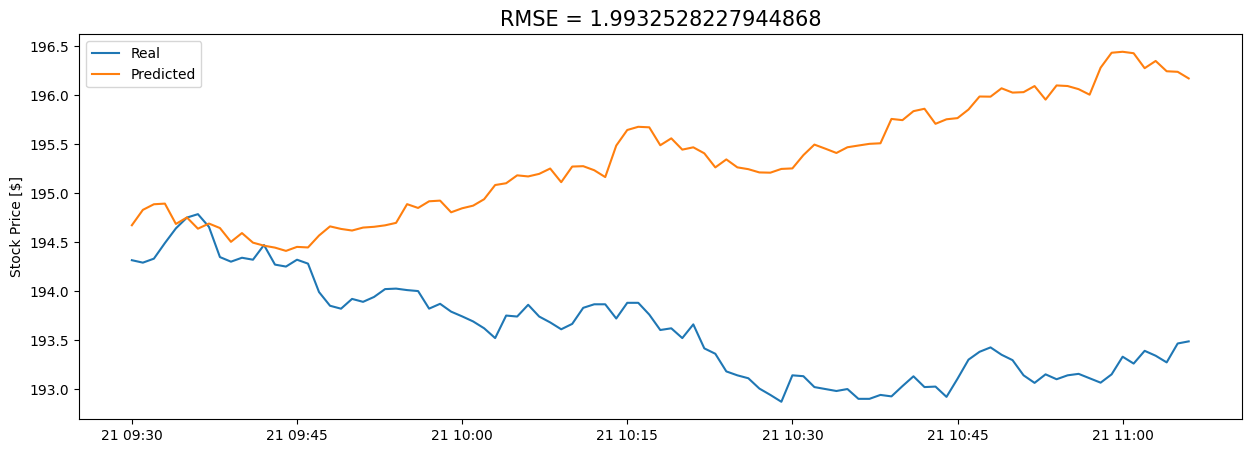

In [129]:
plt.figure(figsize=(15,5))
plt.plot(df.index,df['Adj Close'])
plt.plot(df.index,regression)
plt.ylabel('Stock Price [$]')
plt.legend(['Real','Predicted']);

rmse = np.sqrt(np.mean((df['Adj Close'].values - regression)**2))

plt.title('RMSE = ' + str(rmse), fontsize=15);

In [130]:
def std_filter(std_value):
    
    #Getting dominant values based on std_value
    meanAmp = df['amplitude'].mean()
    stdAmp = df['amplitude'].std()
    dominantAmpCheck = df['amplitude'] > (std_value*stdAmp + meanAmp) 
    positiveFreqCheck = df['freq'] > 0
    dominantAmp = df[dominantAmpCheck & positiveFreqCheck]['amplitude']
    dominantFreq = df[dominantAmpCheck & positiveFreqCheck]['freq']
    dominantTheta = df[dominantAmpCheck & positiveFreqCheck]['theta']
    
    #Calculating Regression Delta
    regressionDelta = 0
    for n in range(len(dominantTheta)):
        shift = dominantTheta[n]
        regressionDelta += dominantAmp[n] * np.cos(n * np.array(range(len(df))) + shift)

    #Converting Delta Time to Time at start value of real data    
    startValue = df['Adj Close'][0]
    regression = startValue - np.cumsum(regressionDelta)
    
    #Calculating RMSE
    rmse = np.sqrt(np.mean((df['Adj Close'].values - regression)**2))
    
    if np.isnan(rmse):
        rmse = 10000000000000
    
    return rmse

In [131]:
std_values = []
rmse_values = []

for i in np.linspace(0,2,20):
    std_values.append(i)
    rmse_values.append(std_filter(i))

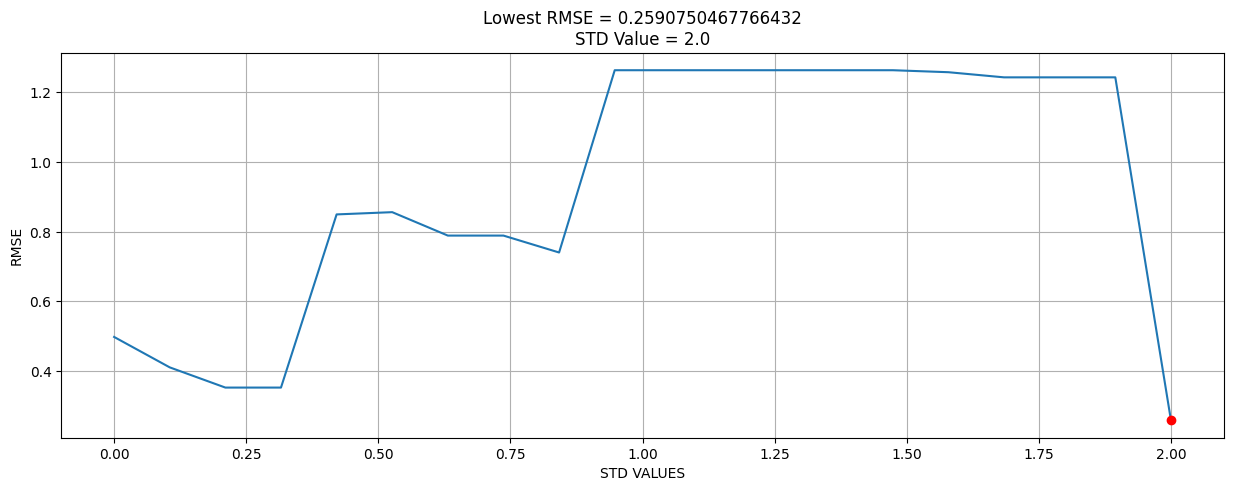

In [132]:
idx = np.array(rmse_values).argmin()
minSTD = std_values[idx]
minRMSE = rmse_values[idx]

plt.figure(figsize=(15,5))
plt.plot(std_values, rmse_values)
plt.plot(minSTD, minRMSE, 'ro')
plt.ylabel('RMSE')
plt.xlabel('STD VALUES')
plt.title('Lowest RMSE = '+str(minRMSE)+'\nSTD Value = '+str(minSTD))
plt.grid()

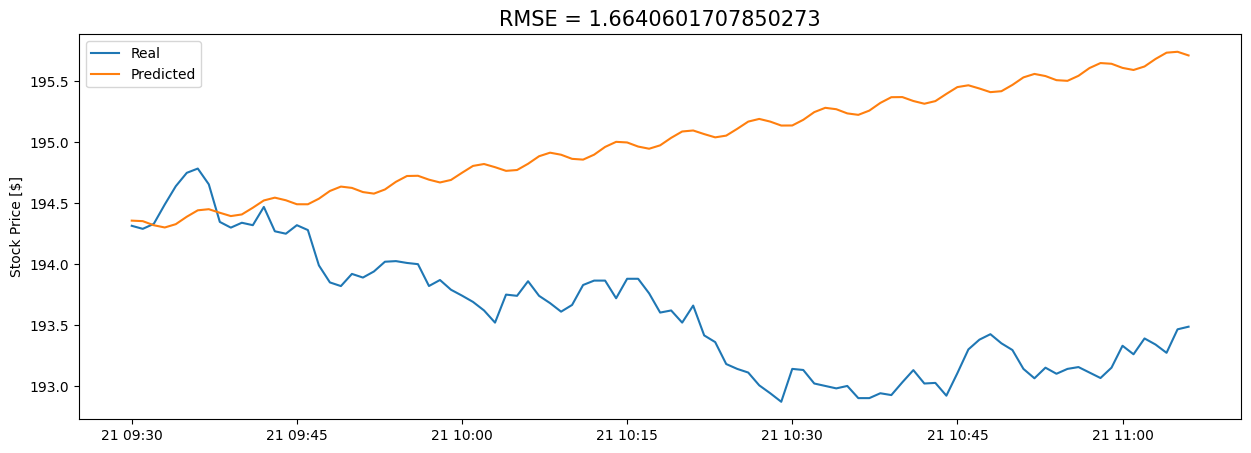

In [133]:
#Getting dominant values based on std_value
meanAmp = df['amplitude'].mean()
stdAmp = df['amplitude'].std()
dominantAmpCheck = df['amplitude'] > (minSTD*stdAmp + meanAmp) 
positiveFreqCheck = df['freq'] > 0
dominantAmp = df[dominantAmpCheck & positiveFreqCheck]['amplitude']
dominantFreq = df[dominantAmpCheck & positiveFreqCheck]['freq']
dominantTheta = df[dominantAmpCheck & positiveFreqCheck]['theta']

#Calculating Regression Delta
regressionDelta = 0
for n in range(len(dominantTheta)):
    shift = dominantTheta[n]
    regressionDelta += dominantAmp[n] * np.cos(n * np.array(range(len(df))) + shift)

#Converting Delta Time to Time at start value of real data    
startValue = df['Adj Close'][0]
regression = startValue + np.cumsum(regressionDelta)

plt.figure(figsize=(15,5))
plt.plot(df.index,df['Adj Close'])
plt.plot(df.index,regression)
plt.ylabel('Stock Price [$]')
plt.legend(['Real','Predicted']);

rmse = np.sqrt(np.mean((df['Adj Close'].values - regression)**2))

plt.title('RMSE = ' + str(rmse), fontsize=15);

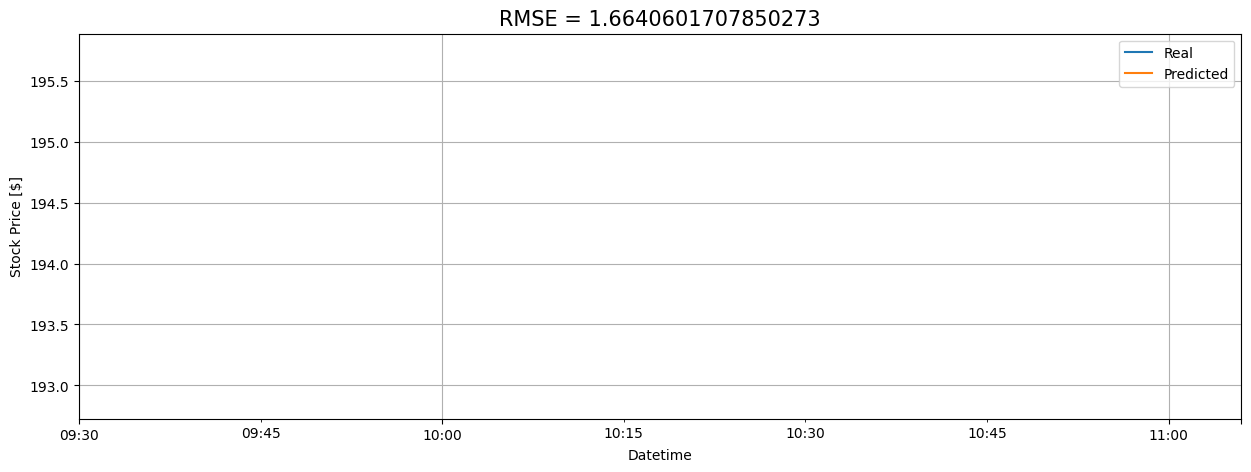

In [125]:
#Calculating Regression Delta
regressionDelta = 0
for n in range(len(dominantTheta)):
    shift = dominantTheta[n]
    regressionDelta += dominantAmp[n] * np.cos(n * np.array(range(len(df))) + shift)

#Converting Delta Time to Time at start value of real data    
startValue = df['Adj Close'][0]
regression = startValue + np.cumsum(regressionDelta)

plt.figure(figsize=(15,5))
df['Adj Close'].plot(grid=True)
plt.plot(df.index,regression)
plt.ylabel('Stock Price [$]')
plt.legend(['Real','Predicted'])

plt.axvline(x=4001, ymin=0, ymax = 1, linewidth=2, color='r')

rmse = np.sqrt(np.mean((df['Adj Close'].values - regression)**2))

plt.title('RMSE = ' + str(rmse), fontsize=15);

[*********************100%***********************]  1 of 1 completed


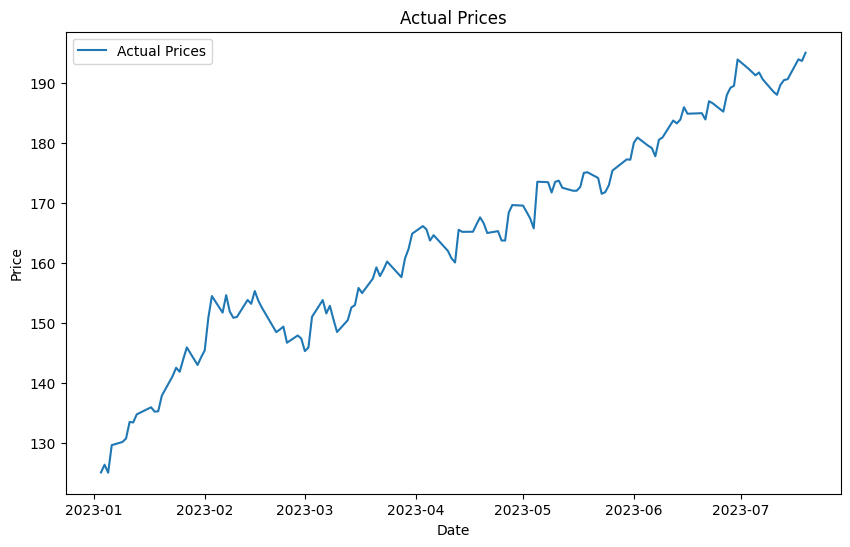

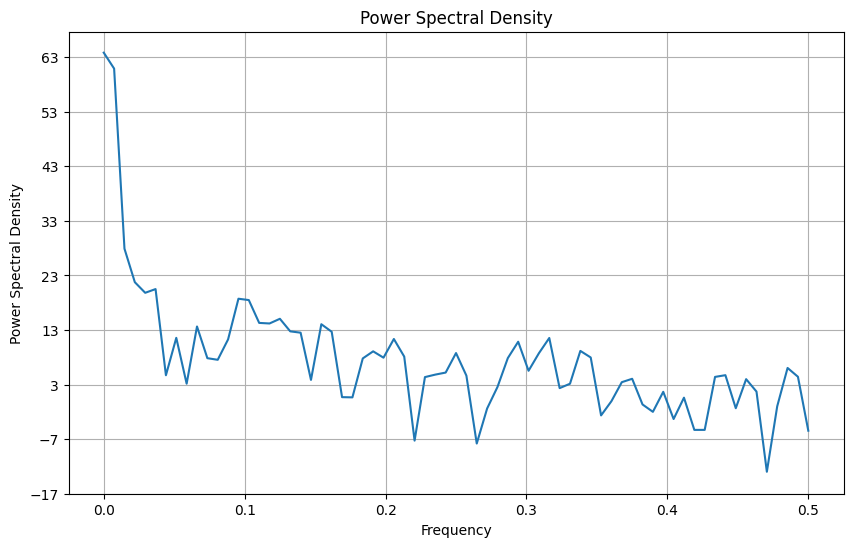

c:\Users\paras\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


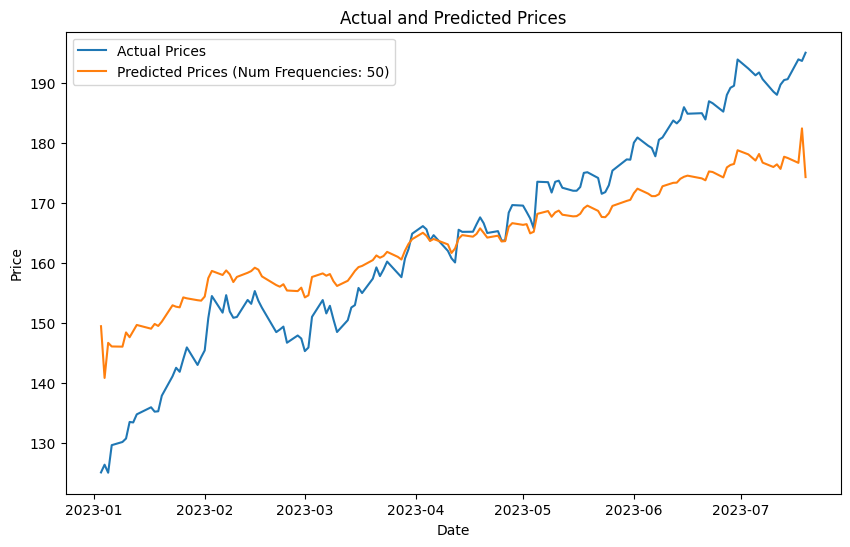

In [134]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

def download_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data['Close']

def plot_prices(data):
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data, label="Actual Prices")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.title("Actual Prices")
    plt.show()

def split_data_fft(data, num_frequencies):
    fft_result = np.fft.fft(data)
    fft_result[num_frequencies:] = 0
    reconstructed_data = np.fft.ifft(fft_result)
    return reconstructed_data

def plot_power_spectral_density(data):
    plt.figure(figsize=(10, 6))
    plt.psd(data, Fs=1, NFFT=len(data))
    plt.xlabel("Frequency")
    plt.ylabel("Power Spectral Density")
    plt.title("Power Spectral Density")
    plt.show()

if __name__ == "__main__":
    ticker = "AAPL"  # Replace with the desired ticker symbol
    start_date = "2023-01-01"
    end_date = "2023-07-20"

    # Step 1: Download data from Yahoo Finance
    data = download_data(ticker, start_date, end_date)

    # Step 2: Plot actual prices
    plot_prices(data)

    # Step 3: Perform FFT and plot the power spectral density
    plot_power_spectral_density(data)

    # Step 4: Reconstruct data using a particular number of frequencies (e.g., 50)
    num_frequencies = 50
    reconstructed_data = split_data_fft(data, num_frequencies)

    # Step 5: Plot the actual and predicted prices
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data, label="Actual Prices")
    plt.plot(data.index, reconstructed_data, label=f"Predicted Prices (Num Frequencies: {num_frequencies})")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.title("Actual and Predicted Prices")
    plt.show()


[*********************100%***********************]  1 of 1 completed


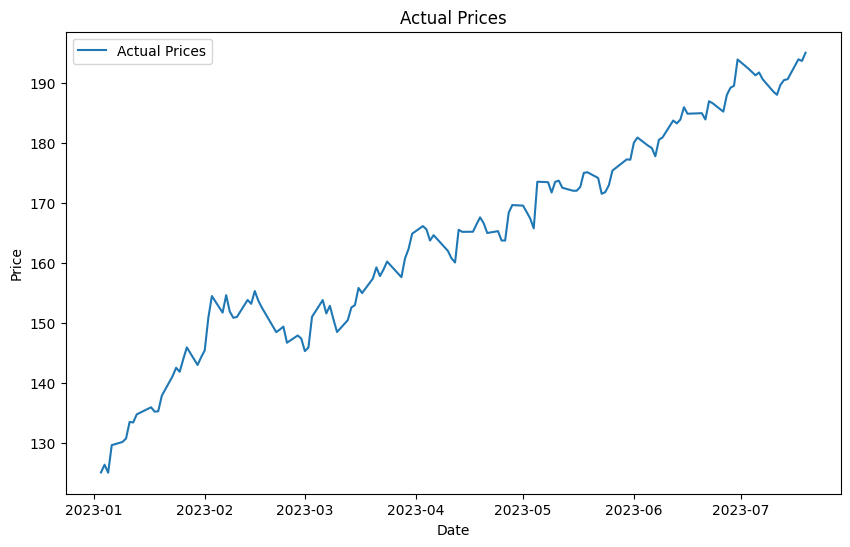

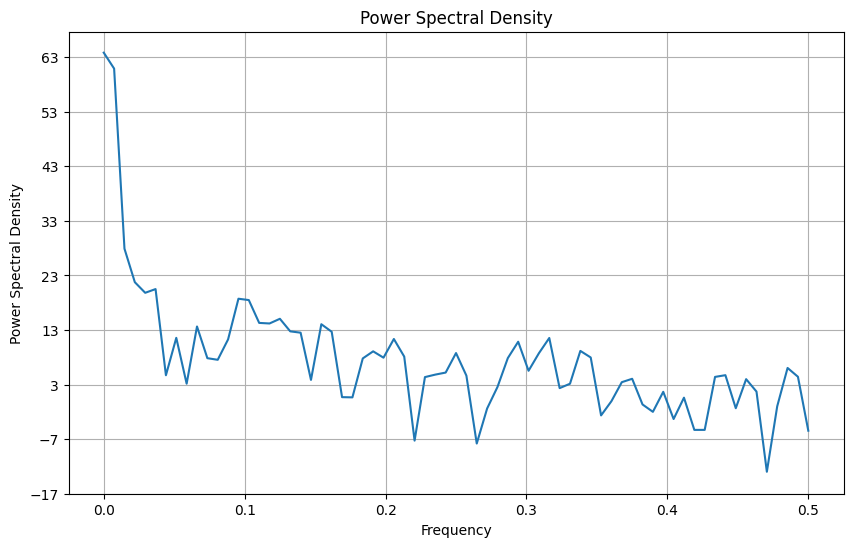

c:\Users\paras\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


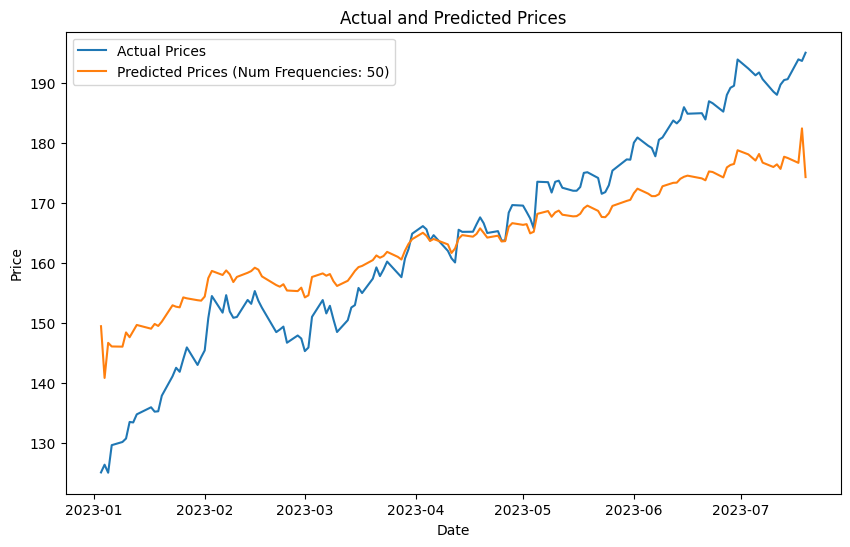

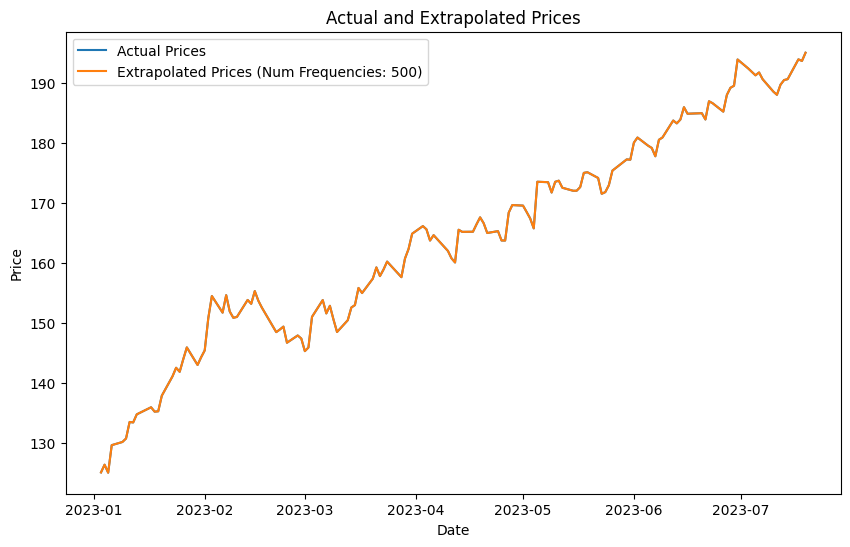

In [135]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

def download_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data['Close']

def plot_prices(data, title):
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data, label="Actual Prices")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.title(title)
    plt.show()

def split_data_fft(data, num_frequencies):
    fft_result = np.fft.fft(data)
    fft_result[num_frequencies:] = 0
    reconstructed_data = np.fft.ifft(fft_result)
    return reconstructed_data

def plot_power_spectral_density(data):
    plt.figure(figsize=(10, 6))
    plt.psd(data, Fs=1, NFFT=len(data))
    plt.xlabel("Frequency")
    plt.ylabel("Power Spectral Density")
    plt.title("Power Spectral Density")
    plt.show()

if __name__ == "__main__":
    ticker = "AAPL"  # Replace with the desired ticker symbol
    start_date = "2023-01-01"
    end_date = "2023-07-20"

    # Step 1: Download data from Yahoo Finance
    data = download_data(ticker, start_date, end_date)

    # Step 2: Plot actual prices
    plot_prices(data, "Actual Prices")

    # Step 3: Perform FFT and plot the power spectral density
    plot_power_spectral_density(data)

    # Step 4: Reconstruct data using a particular number of frequencies (e.g., 50)
    num_frequencies = 50
    reconstructed_data = split_data_fft(data, num_frequencies)

    # Step 5: Plot the actual and predicted prices
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data, label="Actual Prices")
    plt.plot(data.index, reconstructed_data, label=f"Predicted Prices (Num Frequencies: {num_frequencies})")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.title("Actual and Predicted Prices")
    plt.show()

    # Step 6: Extrapolate data by using more frequencies (e.g., 500)
    num_frequencies_extrapolate = 500
    extrapolated_data = split_data_fft(data, num_frequencies_extrapolate)

    # Step 7: Plot the actual and extrapolated prices
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data, label="Actual Prices")
    plt.plot(data.index, extrapolated_data, label=f"Extrapolated Prices (Num Frequencies: {num_frequencies_extrapolate})")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.title("Actual and Extrapolated Prices")
    plt.show()


[*********************100%***********************]  1 of 1 completed


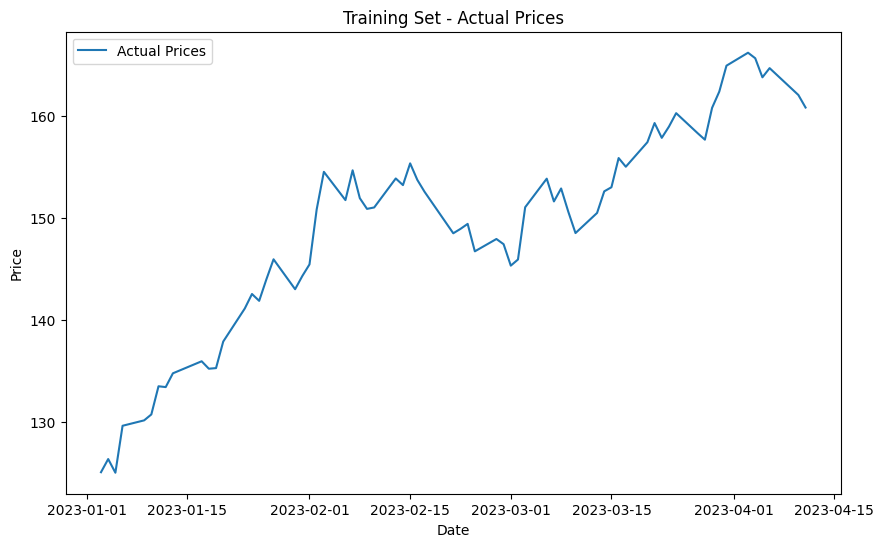

c:\Users\paras\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


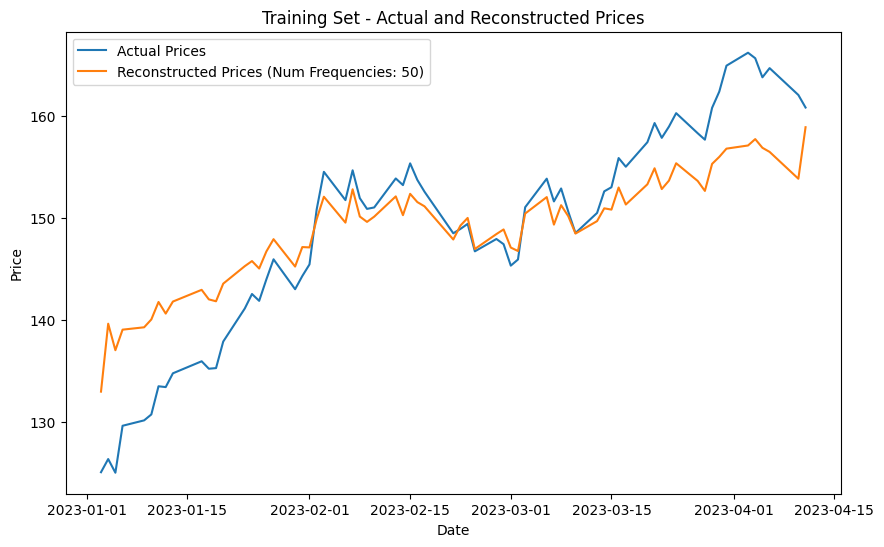

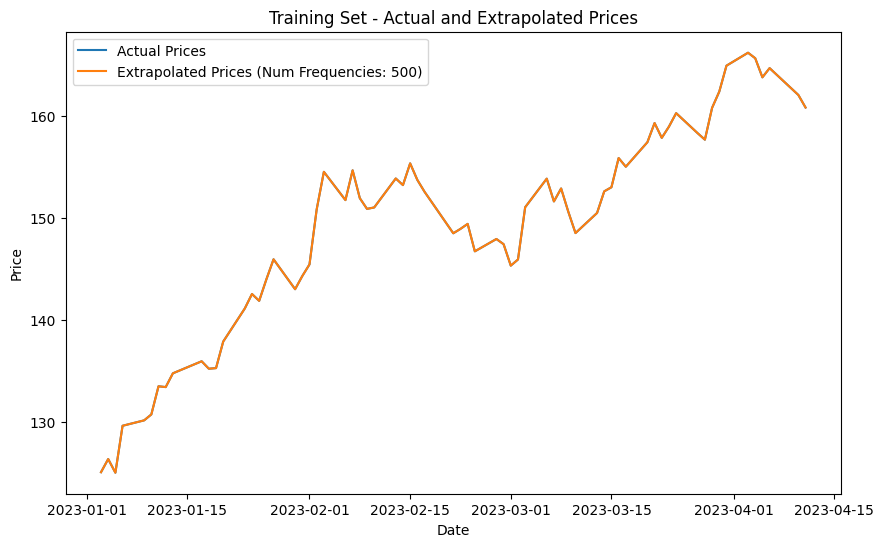

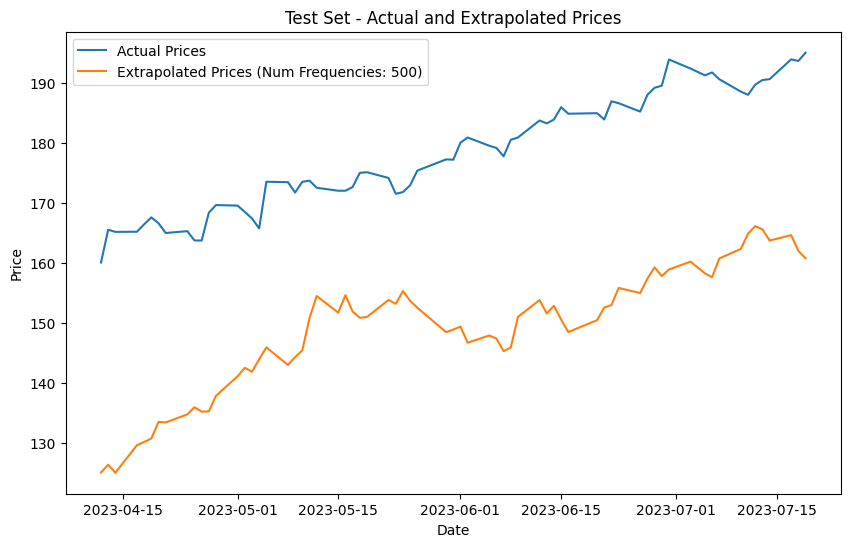

Extrapolation Accuracy: 29.206471387077773


In [136]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

def download_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data['Close']

def plot_prices(data, title):
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data, label="Actual Prices")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.title(title)
    plt.show()

def split_data_fft(data, num_frequencies):
    fft_result = np.fft.fft(data)
    fft_result[num_frequencies:] = 0
    reconstructed_data = np.fft.ifft(fft_result)
    return reconstructed_data

def plot_power_spectral_density(data):
    plt.figure(figsize=(10, 6))
    plt.psd(data, Fs=1, NFFT=len(data))
    plt.xlabel("Frequency")
    plt.ylabel("Power Spectral Density")
    plt.title("Power Spectral Density")
    plt.show()

def extrapolate_data(data, num_frequencies):
    fft_result = np.fft.fft(data)
    fft_result[num_frequencies:] = 0
    extrapolated_data = np.fft.ifft(fft_result)
    return extrapolated_data

def calculate_accuracy(actual_data, predicted_data):
    return np.mean(np.abs(actual_data - predicted_data))

if __name__ == "__main__":
    ticker = "AAPL"  # Replace with the desired ticker symbol
    start_date = "2023-01-01"
    end_date = "2023-07-20"

    # Step 1: Download data from Yahoo Finance
    data = download_data(ticker, start_date, end_date)

    # Step 2: Split the data into train and test sets
    train_data = data.iloc[:len(data) // 2]
    test_data = data.iloc[len(data) // 2:]

    # Step 3: Deconstruct and reconstruct prices using training data
    num_frequencies_train = 50
    reconstructed_data_train = split_data_fft(train_data, num_frequencies_train)

    # Step 4: Plot actual prices for the training set
    plot_prices(train_data, "Training Set - Actual Prices")

    # Step 5: Plot reconstructed prices for the training set
    plt.figure(figsize=(10, 6))
    plt.plot(train_data.index, train_data, label="Actual Prices")
    plt.plot(train_data.index, reconstructed_data_train, label=f"Reconstructed Prices (Num Frequencies: {num_frequencies_train})")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.title("Training Set - Actual and Reconstructed Prices")
    plt.show()

    # Step 6: Extrapolate prices using training data and plot the extrapolated prices
    num_frequencies_extrapolate = 500
    extrapolated_data_train = extrapolate_data(train_data, num_frequencies_extrapolate)

    plt.figure(figsize=(10, 6))
    plt.plot(train_data.index, train_data, label="Actual Prices")
    plt.plot(train_data.index, extrapolated_data_train, label=f"Extrapolated Prices (Num Frequencies: {num_frequencies_extrapolate})")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.title("Training Set - Actual and Extrapolated Prices")
    plt.show()

    # Step 7: Compare extrapolated prices with the test data and calculate accuracy
    extrapolated_data_test = extrapolate_data(train_data, num_frequencies_extrapolate)[-len(test_data):]

    # Step 8: Plot extrapolated and actual prices for the test set
    plt.figure(figsize=(10, 6))
    plt.plot(test_data.index, test_data, label="Actual Prices")
    plt.plot(test_data.index, extrapolated_data_test, label=f"Extrapolated Prices (Num Frequencies: {num_frequencies_extrapolate})")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.title("Test Set - Actual and Extrapolated Prices")
    plt.show()

    # Step 9: Calculate accuracy of the extrapolation
    accuracy = calculate_accuracy(test_data, extrapolated_data_test)
    print("Extrapolation Accuracy:", accuracy)


[*********************100%***********************]  1 of 1 completed


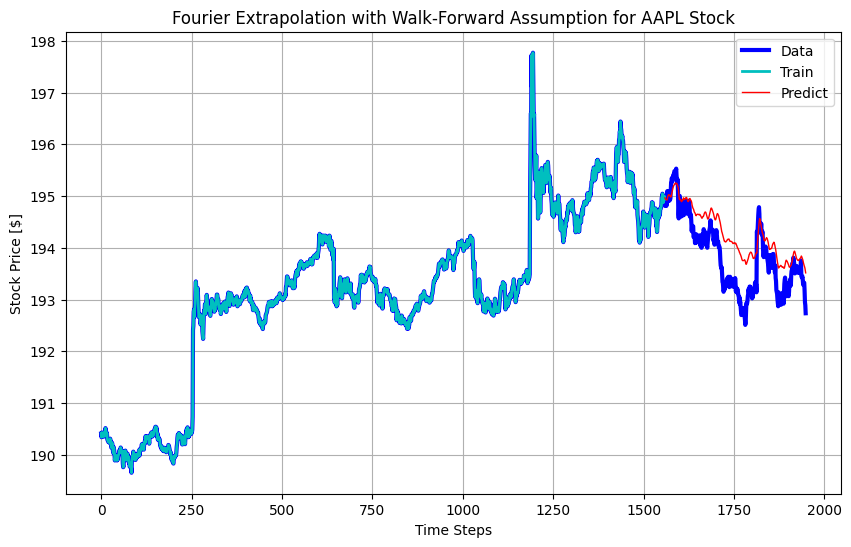

In [142]:
import numpy as np
import pylab as pl
from numpy import fft
from datetime import datetime
from pandas_datareader import data as pdr
import yfinance as yf

def fourierExtrapolation(x, n_predict):
    n = x.size
    n_harm = 100
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)
    x_notrend = x - p[0] * t
    x_freqdom = fft.fft(x_notrend)
    f = fft.fftfreq(n)
    indexes = list(range(n))
    indexes.sort(key=lambda i: np.absolute(f[i]))
    
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n
        phase = np.angle(x_freqdom[i])
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t

# Fetching data for AAPL stock from Yahoo Finance
data = yf.download("AAPL", period="max",interval="1m")
hist = data.loc[:, 'Adj Close'].values

# Initialize variables for walk-forward assumption
train_size = int(len(hist) * 0.8)  # 80% of data for training
n_predict = len(hist) - train_size
predictions = []

# Perform walk-forward assumption for Fourier extrapolation
for i in range(n_predict):
    train = hist[:train_size + i]
    extrapolation = fourierExtrapolation(train, 1)  # Predict one step ahead
    prediction = extrapolation[-1]  # Get the last value as the prediction
    predictions.append(prediction)

# Plotting the results
pl.figure(figsize=(10, 6))
pl.plot(np.arange(0, len(hist)), hist, 'b', label='Data', linewidth=3)
pl.plot(np.arange(0, train_size), hist[:train_size], 'c', label='Train', linewidth=2)
pl.plot(np.arange(train_size, len(hist)), predictions, 'r', label='Predict', linewidth=1)

pl.legend()
pl.title('Fourier Extrapolation with Walk-Forward Assumption for AAPL Stock')
pl.xlabel('Time Steps')
pl.ylabel('Stock Price [$]')
plt.grid()
pl.show()


[*********************100%***********************]  1 of 1 completed


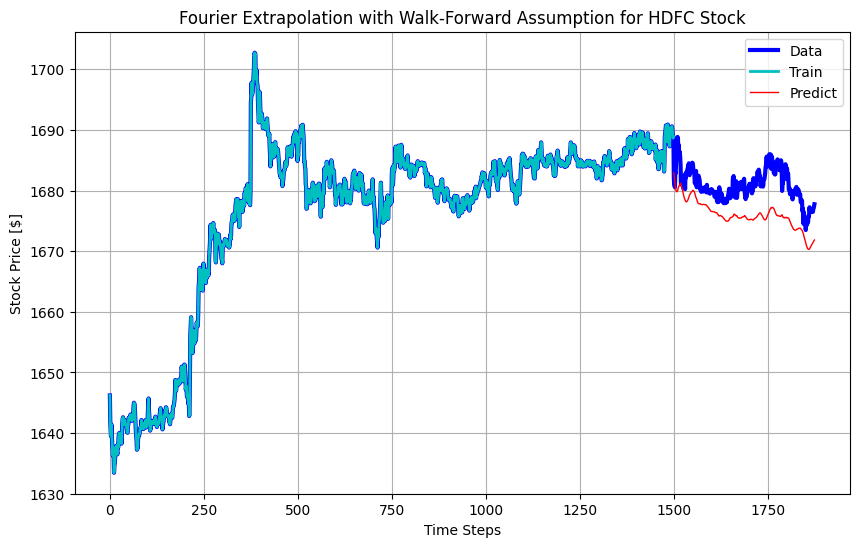

Extrapolation Accuracy: 4.851582642634161


In [174]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import fft
import yfinance as yf

def fourierExtrapolation(x, n_predict):
    n = x.size
    n_harm = 50
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)
    x_notrend = x - p[0] * t
    x_freqdom = fft.fft(x_notrend)
    f = fft.fftfreq(n)
    indexes = list(range(n))
    indexes.sort(key=lambda i: np.absolute(f[i]))

    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n
        phase = np.angle(x_freqdom[i])
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t

# Fetching data for AAPL stock from Yahoo Finance
data = yf.download("HDFCBANK.NS", period="max", interval="1m")
hist = data.loc[:, 'Adj Close'].values

# Initialize variables for walk-forward assumption
train_size = int(len(hist) * 0.8)  # 80% of data for training
n_predict = len(hist) - train_size
predictions = []

# Perform walk-forward assumption for Fourier extrapolation
for i in range(n_predict):
    train = hist[:train_size + i]
    extrapolation = fourierExtrapolation(train, 1)  # Predict one step ahead
    prediction = extrapolation[-1]  # Get the last value as the prediction
    predictions.append(prediction)

# Calculate accuracy by comparing predictions with actual test data
actual_test_data = hist[train_size:]
accuracy = np.mean(np.abs(actual_test_data - predictions))

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(hist)), hist, 'b', label='Data', linewidth=3)
plt.plot(np.arange(train_size), hist[:train_size], 'c', label='Train', linewidth=2)
plt.plot(np.arange(train_size, len(hist)), predictions, 'r', label='Predict', linewidth=1)

plt.legend()
plt.title('Fourier Extrapolation with Walk-Forward Assumption for HDFC Stock')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price [$]')
plt.grid()
plt.show()

print("Extrapolation Accuracy:", accuracy)


[*********************100%***********************]  1 of 1 completed


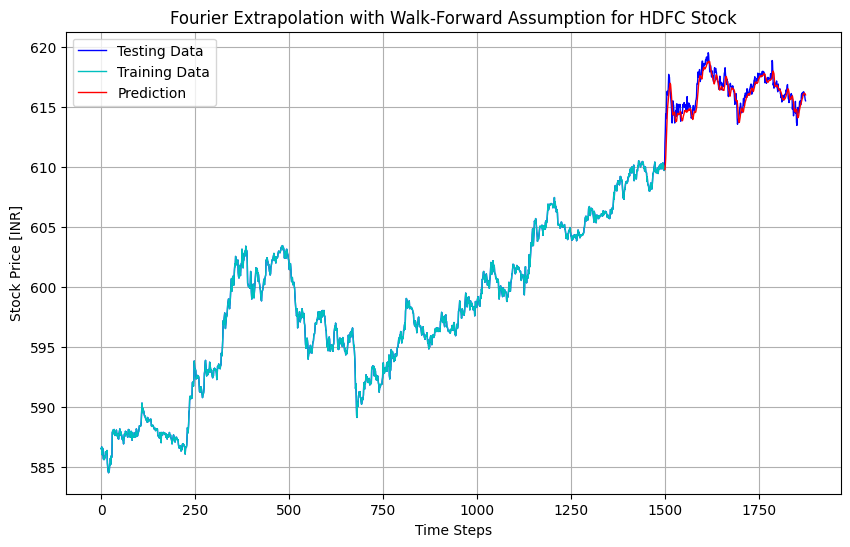

Extrapolation Accuracy: 0.4908469036580315


In [226]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import fft
import yfinance as yf

def fourierExtrapolation(x, n_predict):
    n = x.size
    n_harm = 20
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)
    x_notrend = x - p[0] * t
    x_freqdom = fft.fft(x_notrend)
    f = fft.fftfreq(n)
    indexes = list(range(n))
    indexes.sort(key=lambda i: np.absolute(f[i]))

    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n
        phase = np.angle(x_freqdom[i])
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    restored_sig += p[0] * t
    
    # Calculate the scale factor to match the predicted values with the actual test data
    scale_factor = np.mean(x[-5:]) / np.mean(restored_sig[-5:])
    restored_sig *= scale_factor
    
    return restored_sig

# Fetching data for HDFC Bank stock from Yahoo Finance
data = yf.download("SBIN.NS", period="max", interval="1m")
hist = data.loc[:, 'Adj Close'].values

# Initialize variables for walk-forward assumption
train_size = int(len(hist) * 0.8)  # 80% of data for training
n_predict = len(hist) - train_size
predictions = []

# Perform walk-forward assumption for Fourier extrapolation
for i in range(n_predict):
    train = hist[:train_size + i]
    extrapolation = fourierExtrapolation(train, 1)  # Predict one step ahead
    prediction = extrapolation[-1]  # Get the last value as the prediction
    predictions.append(prediction)

# Calculate accuracy by comparing predictions with actual test data
actual_test_data = hist[train_size:]
accuracy = np.mean(np.abs(actual_test_data - predictions))

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(hist)), hist, 'b', label='Testing Data ', linewidth=1)
plt.plot(np.arange(train_size), hist[:train_size], 'c', label='Training Data', linewidth=1)
plt.plot(np.arange(train_size, len(hist)), predictions, 'r', label='Prediction', linewidth=1)

plt.legend()
plt.title('Fourier Extrapolation with Walk-Forward Assumption for HDFC Stock')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price [INR]')
plt.grid()
plt.show()

print("Extrapolation Accuracy:", accuracy)


[*********************100%***********************]  1 of 1 completed


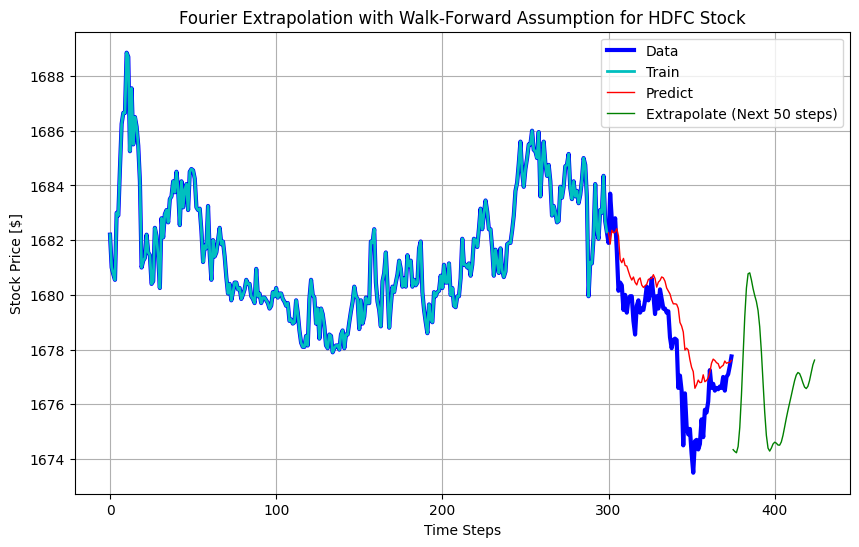

Extrapolation Accuracy: 1.2358665975336407


In [216]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import fft
import yfinance as yf

def fourierExtrapolation(x, n_predict):
    n = x.size
    n_harm = 50
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)
    x_notrend = x - p[0] * t
    x_freqdom = fft.fft(x_notrend)
    f = fft.fftfreq(n)
    indexes = list(range(n))
    indexes.sort(key=lambda i: np.absolute(f[i]))

    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n
        phase = np.angle(x_freqdom[i])
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    restored_sig += p[0] * t
    
    # Calculate the scale factor to match the predicted values with the actual test data
    scale_factor = np.mean(x[-5:]) / np.mean(restored_sig[-5:])
    restored_sig *= scale_factor
    
    return restored_sig

# Fetching data for HDFC Bank stock from Yahoo Finance
data = yf.download("HDFCBANK.NS", period="1d", interval="1m")
hist = data.loc[:, 'Adj Close'].values

# Initialize variables for walk-forward assumption
train_size = int(len(hist) * 0.8)  # 80% of data for training
n_predict = len(hist) - train_size
predictions = []

# Perform walk-forward assumption for Fourier extrapolation
for i in range(n_predict):
    train = hist[:train_size + i]
    extrapolation = fourierExtrapolation(train, 1)  # Predict one step ahead
    prediction = extrapolation[-1]  # Get the last value as the prediction
    predictions.append(prediction)

# Calculate accuracy by comparing predictions with actual test data
actual_test_data = hist[train_size:]
accuracy = np.mean(np.abs(actual_test_data - predictions))

# Extrapolate prices for the next 50 steps
next_50_steps = fourierExtrapolation(hist, 50)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(hist)), hist, 'b', label='Data', linewidth=3)
plt.plot(np.arange(train_size), hist[:train_size], 'c', label='Train', linewidth=2)
plt.plot(np.arange(train_size, len(hist)), predictions, 'r', label='Predict', linewidth=1)
plt.plot(np.arange(len(hist), len(hist) + 50), next_50_steps[-50:], 'g', label='Extrapolate (Next 50 steps)', linewidth=1)

plt.legend()
plt.title('Fourier Extrapolation with Walk-Forward Assumption for HDFC Stock')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price [$]')
plt.grid()
plt.show()

print("Extrapolation Accuracy:", accuracy)


[*********************100%***********************]  1 of 1 completed


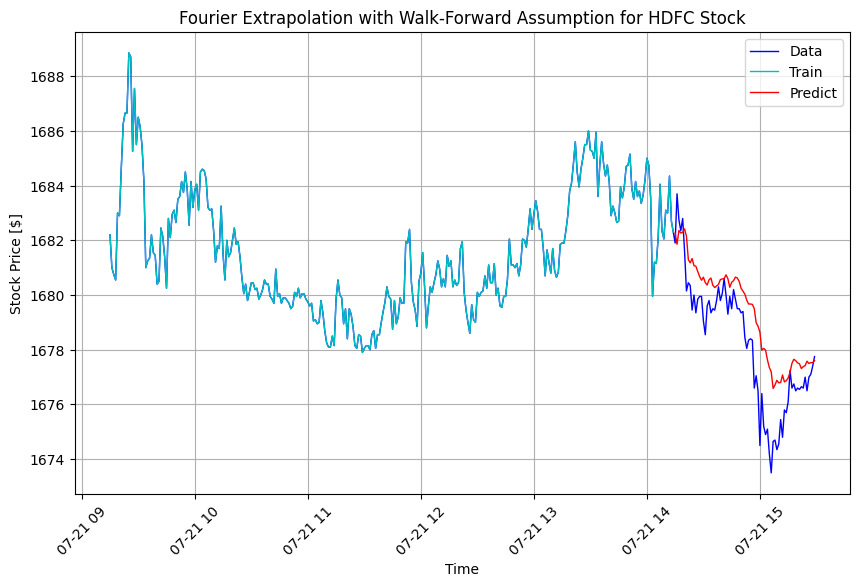

Extrapolation Accuracy: 1.2358665975336407


In [219]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import fft
import yfinance as yf

def fourierExtrapolation(x, n_predict):
    n = x.size
    n_harm = 50
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)
    x_notrend = x - p[0] * t
    x_freqdom = fft.fft(x_notrend)
    f = fft.fftfreq(n)
    indexes = list(range(n))
    indexes.sort(key=lambda i: np.absolute(f[i]))

    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n
        phase = np.angle(x_freqdom[i])
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    restored_sig += p[0] * t
    
    # Calculate the scale factor to match the predicted values with the actual test data
    scale_factor = np.mean(x[-5:]) / np.mean(restored_sig[-5:])
    restored_sig *= scale_factor
    
    return restored_sig
# Fetching data for HDFC Bank stock from Yahoo Finance
data = yf.download("HDFCBANK.NS", period="1d", interval="1m")
hist = data.loc[:, 'Adj Close'].values
timestamps = data.index  # Get the timestamps corresponding to the data points

# Initialize variables for walk-forward assumption
train_size = int(len(hist) * 0.8)  # 80% of data for training
n_predict = len(hist) - train_size
predictions = []

# Perform walk-forward assumption for Fourier extrapolation
for i in range(n_predict):
    train = hist[:train_size + i]
    extrapolation = fourierExtrapolation(train, 1)  # Predict one step ahead
    prediction = extrapolation[-1]  # Get the last value as the prediction
    predictions.append(prediction)

# Calculate accuracy by comparing predictions with actual test data
actual_test_data = hist[train_size:]
accuracy = np.mean(np.abs(actual_test_data - predictions))

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(timestamps, hist, 'b', label='Data', linewidth=1)
plt.plot(timestamps[:train_size], hist[:train_size], 'c', label='Train', linewidth=1)
plt.plot(timestamps[train_size:], predictions, 'r', label='Predict', linewidth=1)

plt.legend()
plt.title('Fourier Extrapolation with Walk-Forward Assumption for HDFC Stock')
plt.xlabel('Time')
plt.ylabel('Stock Price [$]')
plt.grid()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

print("Extrapolation Accuracy:", accuracy)